In [114]:
#%pip install "numpy<2.0" scikit-learn tensorflow adversarial-robustness-toolbox --force-reinstall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import re
from art.estimators.classification import SklearnClassifier, TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

In [115]:
df = pd.read_csv("SQLiV3.csv")
print(df.columns)

Index(['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')


In [116]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3'], errors='ignore')
df = df[df['Label'].isin(['0', '1'])]
df = df[['Sentence', 'Label']].dropna()

df = df.reset_index(drop=True)

df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,AND 1 = utl_inaddr.get_host_address ( ...,1
2,select * from users where id = '1' or @ @1 ...,1
3,"select * from users where id = 1 or 1#"" ( ...",1
4,select name from syscolumns where id = ...,1


In [117]:
# CSV original (non modifié) pour calculer les pourcentages
df_raw = pd.read_csv("SQLiV3.csv")

total = len(df_raw)
count_0 = len(df_raw[df_raw['Label'] == '0'])
count_1 = len(df_raw[df_raw['Label'] == '1'])
autres = total - (count_0 + count_1)

# Pourcentages
pct_0 = (count_0 / total) * 100
pct_1 = (count_1 / total) * 100
pct_autres = (autres / total) * 100

print(f"Total: {total}")
print(f"Label 0 (bénins): {count_0} → {pct_0:.3f}%")
print(f"Label 1 (SQLi)  : {count_1} → {pct_1:.3f}%")
print(f"Autres / bruités: {autres} → {pct_autres:.3f}%")

Total: 30919
Label 0 (bénins): 19268 → 62.318%
Label 1 (SQLi)  : 11341 → 36.680%
Autres / bruités: 310 → 1.003%


In [118]:
print(len(df), "rows in the dataset")

print("Deleting non SQL rows...")
# Check if the sentences are in SQL format
def is_sql(sentence):
    sql_keywords = ['SELECT', 'INSERT', 'UPDATE', 'DELETE', 'WHERE', 'FROM', 'JOIN', 'CREATE', 'DROP']
    return any(keyword in sentence.upper() for keyword in sql_keywords)

df = df[df['Sentence'].apply(is_sql)]
print("Dataset after deletion:", len(df), "rows")

print("Balancing the dataset...")

df_0 = df[df['Label'] == '0']
df_1 = df[df['Label'] == '1']
df_0 = df_0.sample(n=len(df_1), random_state=42)
df = pd.concat([df_0, df_1], ignore_index=True)

# Reset index after filtering
df = df.reset_index(drop=True)

# Display the first few rows of the cleaned dataset
df.head()

30609 rows in the dataset
Deleting non SQL rows...
Dataset after deletion: 19863 rows
Balancing the dataset...


,Sentence,Label
0,"SELECT milkID AS ID, at AS spin FROM object",0
1,SELECT * FROM shore,0
2,"SELECT COUNT ( pond ) , sale FROM mission B...",0
3,"SELECT ship,thread FROM different WHERE hims...",0
4,SELECT * FROM post FETCH FIRST 50 PERCENT ROWS...,0


In [119]:
custom_feature_names = [
    "length",
    "num_quotes",
    "num_equals",
    "num_semicolons",
    "num_keywords",
    "has_comment",
    "has_union",
    "has_sleep",
    "num_digits"
]

def extract_features(sentence):
    return {
        "length": len(sentence),
        "num_quotes": sentence.count("'") + sentence.count('"'),
        "num_equals": sentence.count("="),
        "num_semicolons": sentence.count(";"),
        "num_keywords": len(re.findall(r"\b(select|union|insert|drop|update|or|and|where|sleep|benchmark)\b", sentence, re.IGNORECASE)),
        "has_comment": int("--" in sentence or "/*" in sentence),
        "has_union": int("union" in sentence.lower()),
        "has_sleep": int("sleep" in sentence.lower()),
        "num_digits": sum(c.isdigit() for c in sentence),
    }

X_custom = df['Sentence'].apply(extract_features)
X_custom_df = pd.DataFrame(X_custom.tolist())

# Combine the features
scaler = StandardScaler()
X_custom_scaled = scaler.fit_transform(X_custom_df)

# Labels
y = df['Label']
y = y.to_numpy()

# Recreate the DataFrame with custom features
X_custom_df = pd.DataFrame(X_custom_scaled, columns=custom_feature_names)
df = pd.concat([X_custom_df, df['Label']], axis=1)
df.head()

,length,num_quotes,num_equals,num_semicolons,num_keywords,has_comment,has_union,has_sleep,num_digits,Label
0,-0.608623,-0.749072,-0.900869,-0.120537,-0.963098,-0.503707,-0.428499,-0.221671,-0.691131,0
1,-0.917649,-0.749072,-0.900869,-0.120537,-0.963098,-0.503707,-0.428499,-0.221671,-0.691131,0
2,-0.454110,-0.749072,-0.900869,-0.120537,-0.963098,-0.503707,-0.428499,-0.221671,-0.691131,0
3,-0.002457,0.308609,0.210883,-0.120537,1.362424,-0.503707,2.333728,-0.221671,-0.691131,0
4,-0.537309,-0.749072,-0.900869,-0.120537,-0.963098,-0.503707,-0.428499,-0.221671,-0.563896,0


In [120]:
df.describe()

,length,num_quotes,num_equals,num_semicolons,num_keywords,has_comment,has_union,has_sleep,num_digits
count,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04,1.710200e+04
mean,1.994273e-17,-4.653303e-17,7.644712e-17,-3.240693e-17,1.130088e-16,-1.329515e-17,7.312333e-17,4.653303e-17,-6.647576e-17
std,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00,1.000029e+00
min,-1.072162e+00,-7.490725e-01,-9.008686e-01,-1.205373e-01,-1.738272e+00,-5.037067e-01,-4.284989e-01,-2.216711e-01,-6.911313e-01
25%,-6.086230e-01,-7.490725e-01,-9.008686e-01,-1.205373e-01,-9.630977e-01,-5.037067e-01,-4.284989e-01,-2.216711e-01,-6.911313e-01
50%,-3.590251e-01,-2.202318e-01,2.108831e-01,-1.205373e-01,-1.879237e-01,-5.037067e-01,-4.284989e-01,-2.216711e-01,-5.002782e-01
75%,1.877130e-01,3.086090e-01,2.108831e-01,-1.205373e-01,5.872503e-01,-5.037067e-01,-4.284989e-01,-2.216711e-01,3.267523e-01
max,5.144013e+00,6.125857e+00,7.993145e+00,3.630046e+01,7.563816e+00,1.985282e+00,2.333728e+00,4.511187e+00,1.018750e+01


In [121]:
total = len(df)
count_0 = len(df[df['Label'] == '0'])
count_1 = len(df[df['Label'] == '1'])
autres = total - (count_0 + count_1)

# Pourcentages
pct_0 = (count_0 / total) * 100
pct_1 = (count_1 / total) * 100
pct_autres = (autres / total) * 100

print(f"Total: {total}")
print(f"Label 0 (bénins): {count_0} → {pct_0:.3f}%")
print(f"Label 1 (SQLi)  : {count_1} → {pct_1:.3f}%")
print(f"Autres / bruités: {autres} → {pct_autres:.3f}%")

Total: 17102
Label 0 (bénins): 8551 → 50.000%
Label 1 (SQLi)  : 8551 → 50.000%
Autres / bruités: 0 → 0.000%


Accuracy: 0.999


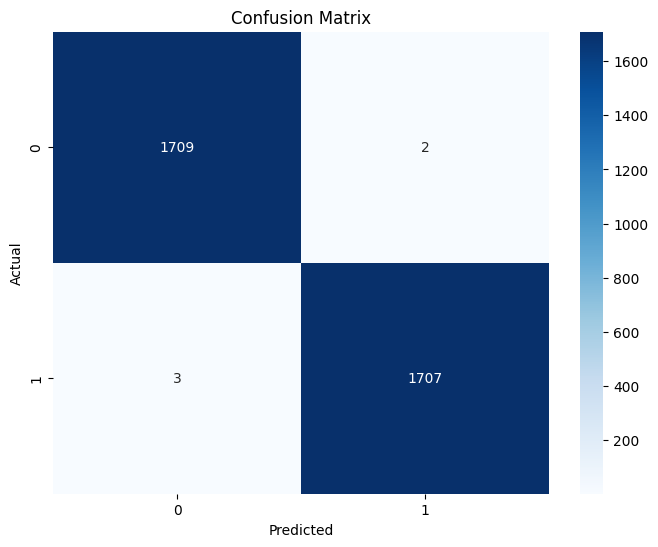

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X_custom_scaled, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [123]:
# Calculate precision and recall
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Calculate f1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-score: {f1_score:.3f}")

Precision: 0.999
Recall: 0.998
F1-score: 0.999


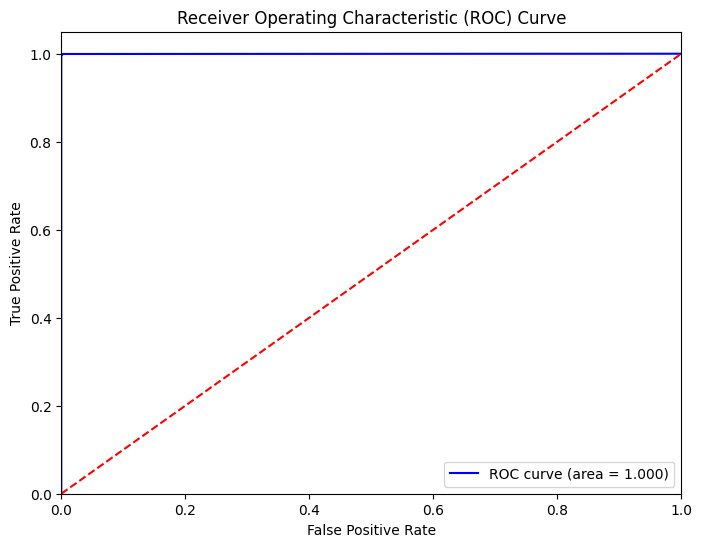

In [124]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1], pos_label='1')
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

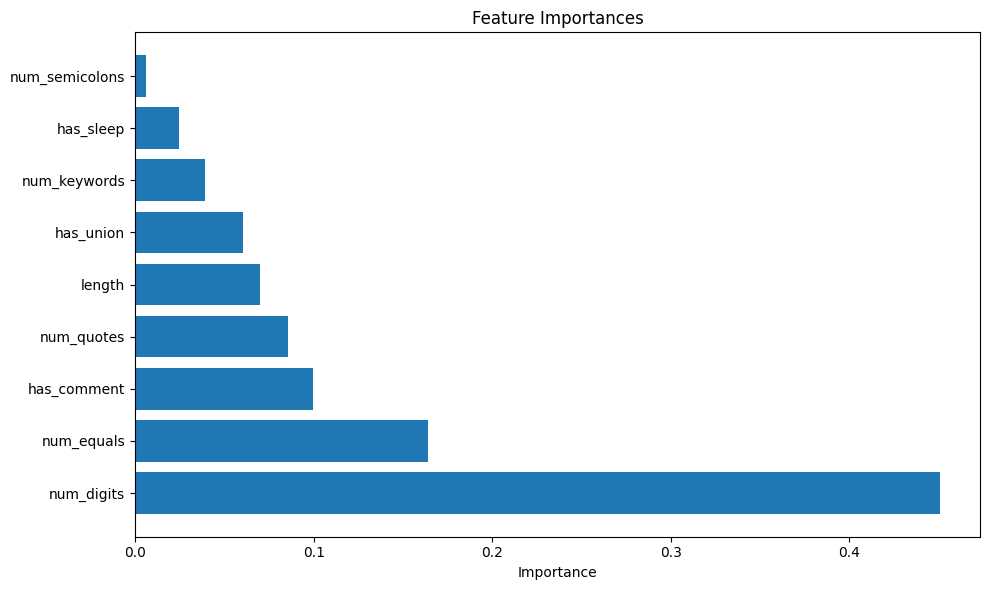

In [125]:
importances = clf.feature_importances_
feature_names = custom_feature_names

# Sort features by importance
indices = importances.argsort()[::-1]
importances = importances[indices]
feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


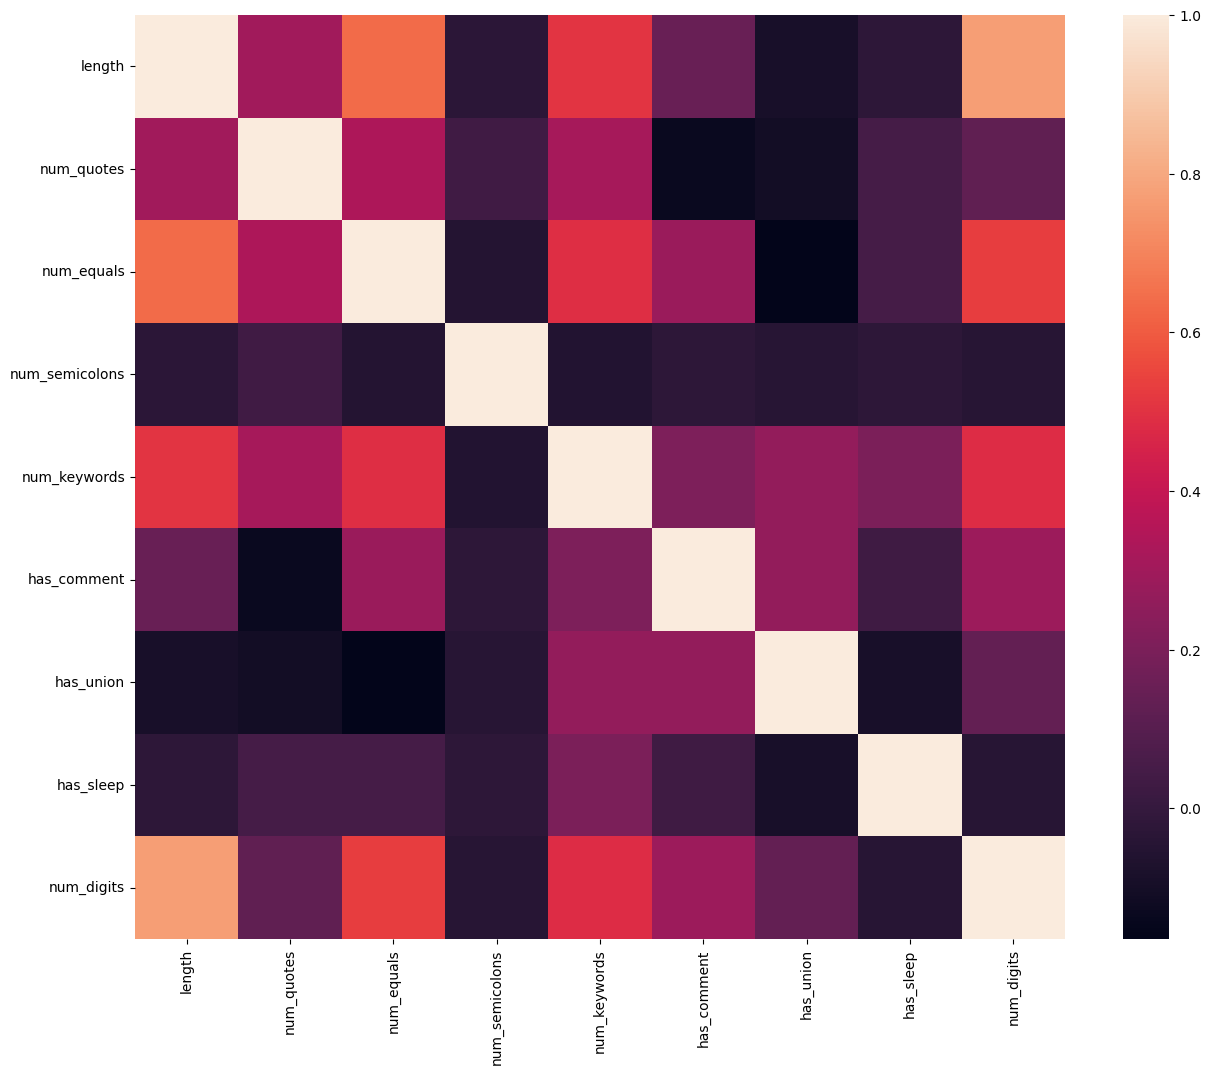

In [126]:
# Calcul de la matrice de corrélation
corr = pd.DataFrame(X_custom_scaled, columns=custom_feature_names).corr()

plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()

Accuracy: 0.953


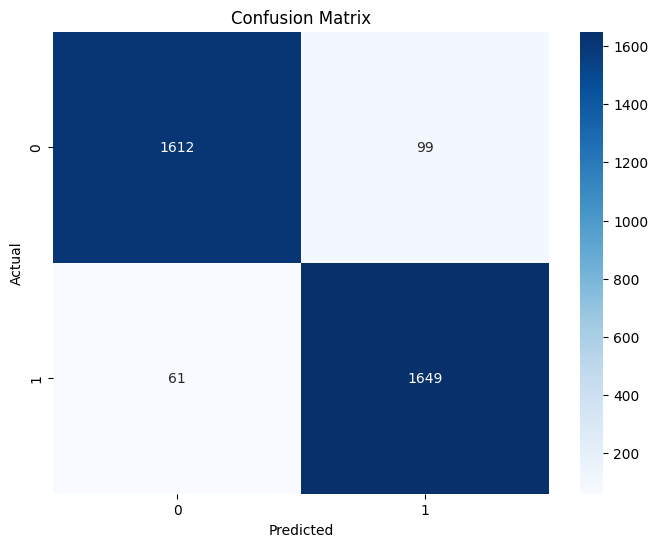

Precision: 0.943
Recall: 0.964
F1-score: 0.954


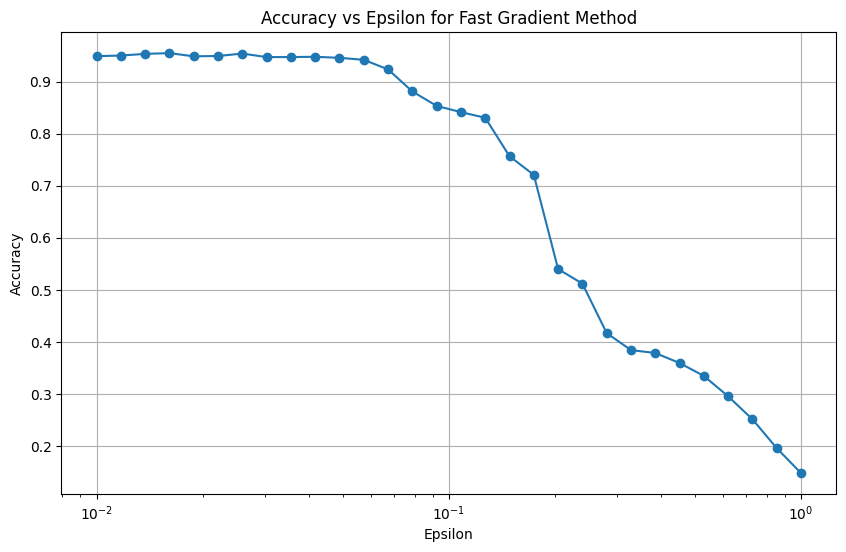

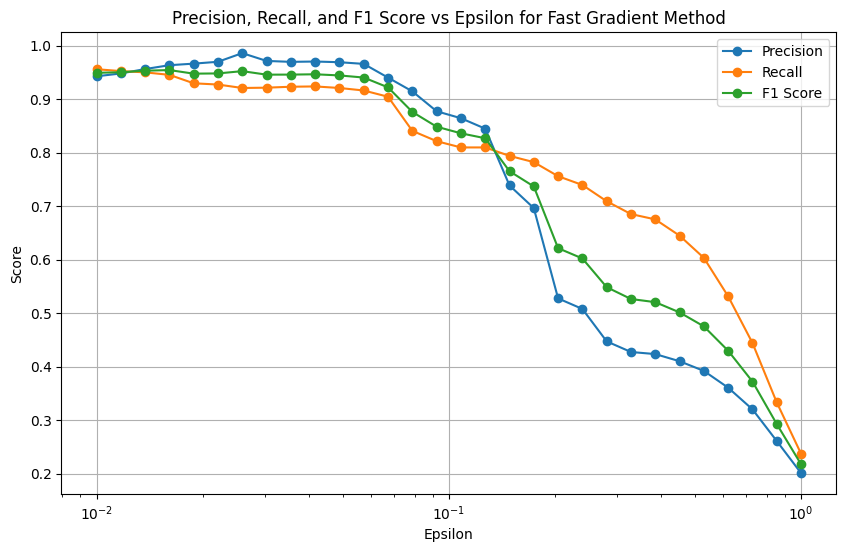

In [127]:
epsilons = np.logspace(-2, 0, num=30)

# Entraîner le modèle
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.3f}")

# Afficher la matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Calculate precision and recall
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1]) if (cm[1, 1] + cm[0, 1]) > 0 else 0
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0]) if (cm[1, 1] + cm[1, 0]) > 0 else 0
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Calculate f1-score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-score: {f1_score:.3f}")

accuracies = []
precisions = []
recalls = []
f1_scores = []

# Boucle sur les valeurs d'epsilon
for epsilon in epsilons:
    # Créer l'estimateur ART
    classifier = SklearnClassifier(model=model)
    # Créer l'attaque
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    # Générer les exemples adverses
    X_test_adv = attack.generate(x=X_test)
    # Évaluer le modèle sur les exemples adverses
    y_pred_adv = classifier.predict(X_test_adv)
    y_pred_adv_classes = np.argmax(y_pred_adv, axis=1)
    # Calculer l'accuracy sur les exemples adverses
    accuracy_adv = accuracy_score(y_test.astype(int), y_pred_adv_classes)
    accuracies.append(accuracy_adv)
    # Calculer la précision, le rappel et le F1-score
    precision = np.sum((y_test.astype(int) == 1) & (y_pred_adv_classes == 1)) / np.sum(y_pred_adv_classes == 1)
    recall = np.sum((y_test.astype(int) == 1) & (y_pred_adv_classes == 1)) / np.sum(y_test.astype(int) == 1)
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1_score)
    
# Afficher les résultats
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title('Accuracy vs Epsilon for Fast Gradient Method')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(epsilons, precisions, marker='o', label='Precision')
plt.plot(epsilons, recalls, marker='o', label='Recall')
plt.plot(epsilons, f1_scores, marker='o', label='F1 Score')
plt.title('Precision, Recall, and F1 Score vs Epsilon for Fast Gradient Method')
plt.xlabel('Epsilon')
plt.ylabel('Score')
plt.xscale('log')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\natha\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - accuracy: 0.9116 - loss: 0.2383 - val_accuracy: 0.9839 - val_loss: 0.0715
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9847 - loss: 0.0560 - val_accuracy: 0.9832 - val_loss: 0.0543
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9896 - loss: 0.0383 - val_accuracy: 0.9898 - val_loss: 0.0453
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.9907 - loss: 0.0339 - val_accuracy: 0.9894 - val_loss: 0.0409
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.9916 - loss: 0.0273 - val_accuracy: 0.9916 - val_loss: 0.0302
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.9914 - loss: 0.0284 - val_accuracy: 0.9938 - val_loss: 0.0288
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9930 - loss: 0.0273 - val_accuracy: 0.9909 - val_loss: 0.0298
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.9938 - loss: 0.0241 - val_accu

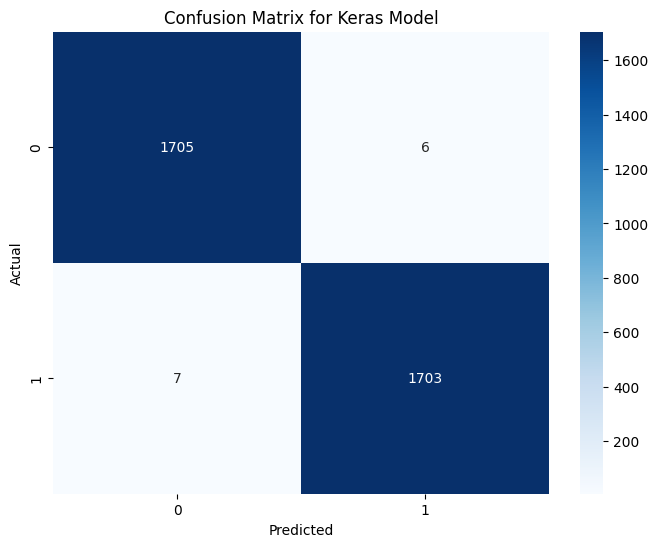

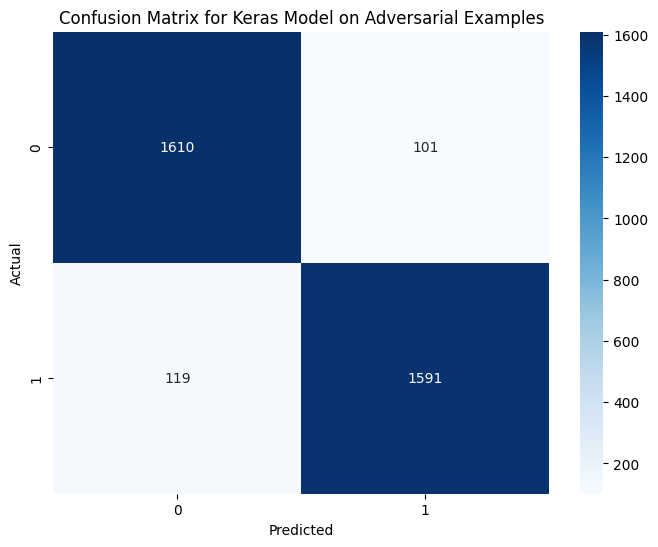

Precision: 0.996
Recall: 0.996
F1-score: 0.996
Precision: 0.940
Recall: 0.930
F1-score: 0.935


In [128]:
input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))

def create_keras_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer le modèle Keras
model_keras = create_keras_model(input_shape, num_classes)
# Entraîner le modèle Keras
model_keras.fit(X_train, y_train.astype(int), epochs=10, batch_size=32, validation_split=0.2)
# Créer l'estimateur ART pour le modèle Keras
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
classifier_keras = TensorFlowV2Classifier(model=model_keras, input_shape=input_shape, nb_classes=num_classes, loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer)
# Créer l'attaque Fast Gradient Method pour le modèle Keras
attack_keras = FastGradientMethod(estimator=classifier_keras, eps=0.1)
# Générer les exemples adverses
X_test_adv_keras = attack_keras.generate(x=X_test)
# Évaluer le modèle Keras sur les exemples adverses
y_pred_adv_keras = classifier_keras.predict(X_test_adv_keras)
y_pred_adv_classes_keras = np.argmax(y_pred_adv_keras, axis=1)
# Calculer l'accuracy sur les exemples adverses
accuracy_adv_keras = accuracy_score(y_test.astype(int), y_pred_adv_classes_keras)

y_pred_keras = model_keras.predict(X_test)
accuracy = accuracy_score(y_test.astype(int), np.argmax(y_pred_keras, axis=1))

print(f"Normal accuracy: {accuracy:.3f}")
print(f"Accuracy on adversarial examples (Keras model): {accuracy_adv_keras:.3f}")

# Display the confusion matrix for the Keras model
cm_keras = confusion_matrix(y_test.astype(int), np.argmax(y_pred_keras, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Keras Model')
plt.show()

cm_keras_adv = confusion_matrix(y_test.astype(int), np.argmax(y_pred_adv_keras, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_keras_adv, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Keras Model on Adversarial Examples')
plt.show()

# Calculate precision and recall for the Keras model
precision = cm_keras[1, 1] / (cm_keras[1, 1] + cm_keras[0, 1]) if (cm_keras[1, 1] + cm_keras[0, 1]) > 0 else 0
recall = cm_keras[1, 1] / (cm_keras[1, 1] + cm_keras[1, 0]) if (cm_keras[1, 1] + cm_keras[1, 0]) > 0 else 0
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Calculate f1-score for the Keras model
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-score: {f1_score:.3f}")

# Calculate precision and recall for the Keras model on adversarial examples
precision = cm_keras_adv[1, 1] / (cm_keras_adv[1, 1] + cm_keras_adv[0, 1]) if (cm_keras_adv[1, 1] + cm_keras_adv[0, 1]) > 0 else 0
recall = cm_keras_adv[1, 1] / (cm_keras_adv[1, 1] + cm_keras_adv[1, 0]) if (cm_keras_adv[1, 1] + cm_keras_adv[1, 0]) > 0 else 0
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Calculate f1-score for the Keras model on adversarial examples
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-score: {f1_score:.3f}")

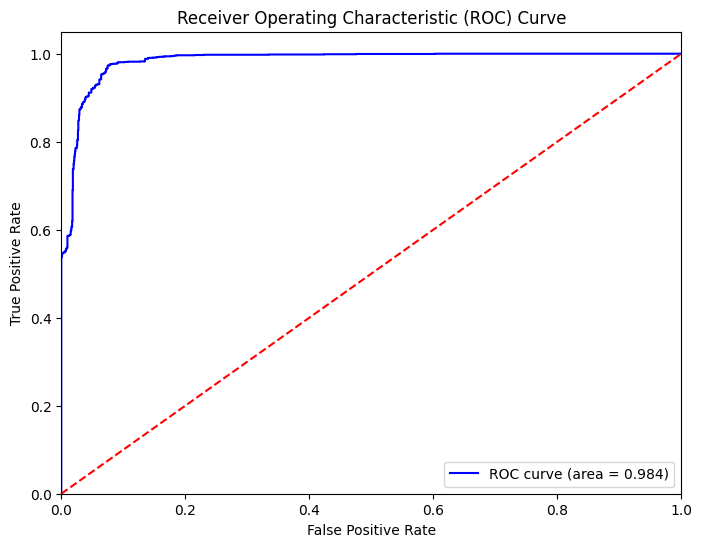

In [129]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, classifier_keras.predict(X_test_adv_keras)[:, 1], pos_label='1')
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on adversarial examples after adversarial training: 0.991


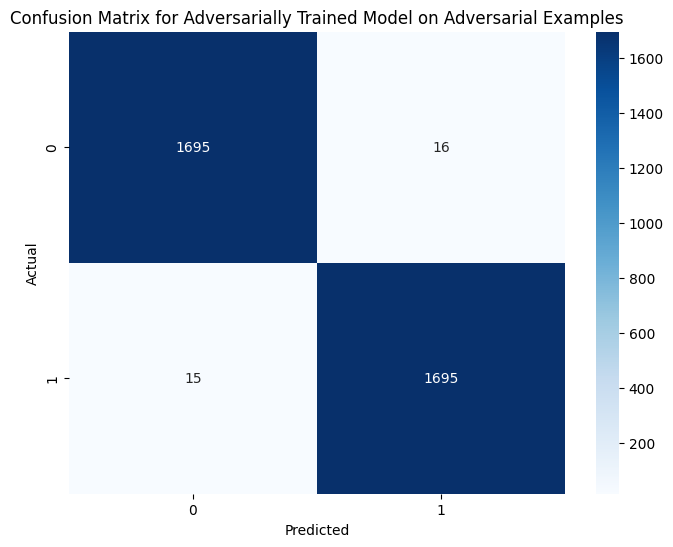

Precision: 0.991
Recall: 0.991
F1-score: 0.991


In [130]:
# Building the Adversarial Trainer
adversarial_trainer = AdversarialTrainer(
    classifier=classifier_keras,
    attacks=FastGradientMethod(classifier_keras, eps=0.1),
    ratio=0.5
)

# Training the model with adversarial examples
adversarial_trainer.fit(X_train, y_train, nb_epochs=10, batch_size=32, validation_split=0.2)
# Evaluate the adversarially trained model
y_pred_adv_trained = adversarial_trainer.classifier.predict(X_test_adv_keras)
y_pred_adv_classes_trained = np.argmax(y_pred_adv_trained, axis=1)
# Calculate accuracy on adversarial examples after adversarial training
accuracy_adv_trained = accuracy_score(y_test.astype(int), y_pred_adv_classes_trained)
print(f"Accuracy on adversarial examples after adversarial training: {accuracy_adv_trained:.3f}")
# Display the confusion matrix for the adversarially trained model
cm_adv_trained = confusion_matrix(y_test.astype(int), y_pred_adv_classes_trained)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adv_trained, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Adversarially Trained Model on Adversarial Examples')
plt.show()

# Calculate precision and recall for the adversarially trained model
precision = cm_adv_trained[1, 1] / (cm_adv_trained[1, 1] + cm_adv_trained[0, 1]) if (cm_adv_trained[1, 1] + cm_adv_trained[0, 1]) > 0 else 0
recall = cm_adv_trained[1, 1] / (cm_adv_trained[1, 1] + cm_adv_trained[1, 0]) if (cm_adv_trained[1, 1] + cm_adv_trained[1, 0]) > 0 else 0
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Calculate f1-score for the adversarially trained model
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"F1-score: {f1_score:.3f}")

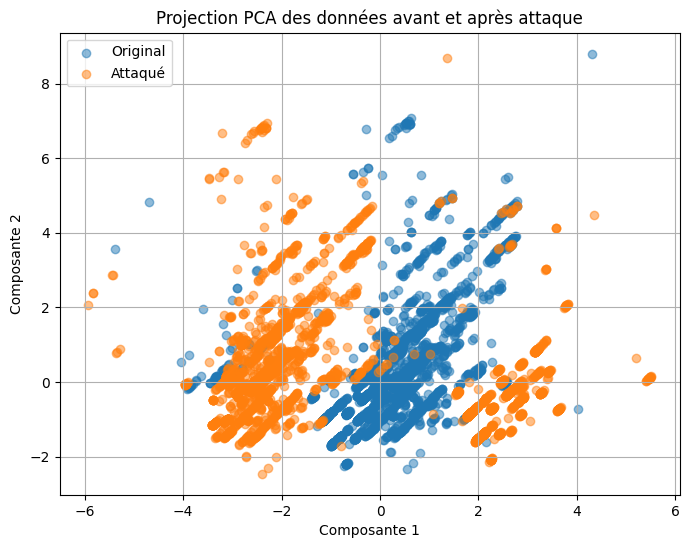

In [131]:
# Données originales et attaquées
X_all = np.concatenate([X_test, X_test_adv])
y_all = np.concatenate([
    np.zeros(len(X_test)),      # étiquette 0 : données originales
    np.ones(len(X_test_adv))    # étiquette 1 : données attaquées
])

# Réduction de dimension avec PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[y_all == 0, 0], X_pca[y_all == 0, 1], label="Original", alpha=0.5)
plt.scatter(X_pca[y_all == 1, 0], X_pca[y_all == 1, 1], label="Attaqué", alpha=0.5)
plt.title("Projection PCA des données avant et après attaque")
plt.xlabel("Composante 1")
plt.ylabel("Composante 2")
plt.legend()
plt.grid(True)
plt.show()